# Квантизация нейронных сетей

Нейронные сети - это модели, которые могут быть потенциально произвольно сложными. Помимо того, что теперь для обучения таких моделей нам требуются гигантские датасеты, сами модели стали слишком большими. 

Это означает, что они занимают очень много места и например могут физически не помещаться на устройство пользователя. А также они очень медленно делают предсказания.

В этот раз поговорим про квантизацию и то, как она помогает сделать модели быстрее и меньше.

## Часть 1. Классическая теория


Пойдем по этому блогпосту:
https://leimao.github.io/article/Neural-Networks-Quantization/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import copy

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from torch.quantization import QuantStub, DeQuantStub

In [3]:
SEED=9876
torch.manual_seed(SEED)

Вновь пробуем обучить сеть из трех полносвязных слоев на fashion mnist.

In [6]:
!wget https://media.githubusercontent.com/media/fpleoni/fashion_mnist/master/fashion-mnist_train.csv
!wget https://media.githubusercontent.com/media/fpleoni/fashion_mnist/master/fashion-mnist_test.csv

--2024-03-21 00:44:27--  https://media.githubusercontent.com/media/fpleoni/fashion_mnist/master/fashion-mnist_train.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133047193 (127M) [text/plain]
Saving to: ‘fashion-mnist_train.csv’

fashion-mnist_train 100%[===================>] 126.88M   123MB/s    in 1.0s    

2024-03-21 00:44:32 (123 MB/s) - ‘fashion-mnist_train.csv’ saved [133047193/133047193]

--2024-03-21 00:44:32--  https://media.githubusercontent.com/media/fpleoni/fashion_mnist/master/fashion-mnist_test.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTT

In [4]:
train_csv = pd.read_csv("fashion-mnist_train.csv")
test_csv = pd.read_csv("fashion-mnist_test.csv")

In [5]:
device = torch.device("cpu")

In [6]:
train_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y_train = train_csv['label'].values
X_train = train_csv.drop(['label'],axis=1).values

y_test = test_csv['label'].values
X_test = test_csv.drop(['label'],axis=1).values

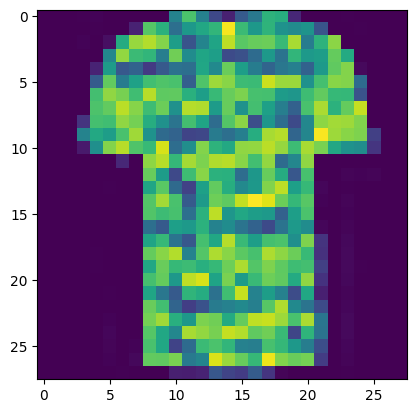

In [8]:
plt.imshow(X_train[3].reshape(28, 28))

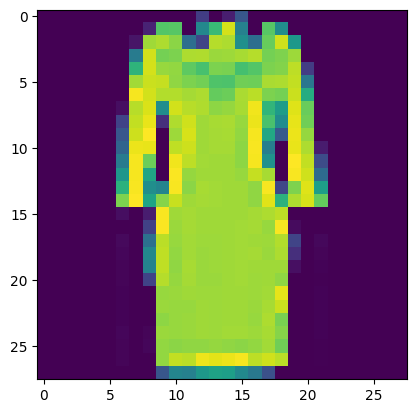

In [9]:
plt.imshow(X_train[4].reshape(28, 28))

In [10]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return X

mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [16]:
def fit(model, train_loader, epoch_number=2):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 200 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [17]:
def evaluate(model, loader=test_loader):
    correct = 0 
    for test_imgs, test_labels in loader:
        test_imgs = Variable(test_imgs).float()
        
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(loader)*BATCH_SIZE)))

In [18]:
torch.manual_seed(SEED)
fit(mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 0.392104	 Accuracy:90.625%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.481568	 Accuracy:83.302%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.661964	 Accuracy:82.941%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.290032	 Accuracy:82.992%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.271368	 Accuracy:83.002%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.549211	 Accuracy:82.986%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.501826	 Accuracy:83.157%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.387613	 Accuracy:83.315%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.167846	 Accuracy:83.401%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.148662	 Accuracy:83.487%
Epoch : 1 [0/60000 (0%)]	Loss: 0.448169	 Accuracy:87.500%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.496726	 Accuracy:84.981%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.665119	 Accuracy:84.624%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.241231	 Accuracy:84.900%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.261912	 Accuracy:84.988%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.515492	 Accuracy:84.915%
Epoc

In [19]:
evaluate(mlp)

Test accuracy:0.857% 


Уменьшать количество самих весов в этот раз мы не будем, поэтому в качестве размера нейронной сети будет использовать буквально количество памяти, которая она занимает.

In [20]:
def calc_size(model):
    torch.save(model.state_dict(), "/tmp/model.p")
    size=os.path.getsize("/tmp/model.p")
    os.remove('/tmp/model.p')
    return "{:.3f} KB".format(size / 1024)

In [21]:
calc_size(mlp)

'870.926 KB'

Полученная сеть весит почти мегабайт.

Посмотрим на веса, которые используются внутри нашей сети

In [22]:
mlp.linear1.weight

Parameter containing:
tensor([[ 0.0326,  0.0279,  0.0418,  ..., -0.0028,  0.0241,  0.0297],
        [-0.0152,  0.0219, -0.0283,  ..., -0.0007, -0.0119,  0.0365],
        [-0.0097, -0.0296,  0.0242,  ..., -0.0385,  0.0172,  0.0285],
        ...,
        [-0.0203, -0.0002,  0.0249,  ...,  0.0117,  0.0209,  0.0146],
        [-0.0187, -0.0464,  0.0138,  ...,  0.0272, -0.0126, -0.0211],
        [-0.0037,  0.0156,  0.0021,  ..., -0.0133, -0.0365,  0.0120]],
       requires_grad=True)

In [23]:
mlp

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)

Посчитаем дополнительно, за сколько в среднем она делает предсказания. Для замеров по времени будем использовать один поток, чтобы все сети были в одинаковых условиях.

In [24]:
from contextlib import contextmanager

@contextmanager
def single_thread():  
    num = torch.get_num_threads()
    torch.set_num_threads(1)
    yield
    torch.set_num_threads(num)

In [25]:
%%timeit -r10

with single_thread():
    evaluate(mlp, train_loader)

Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
2.09 s ± 17.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


### Динамическая квантизация

Динамическая квантизация - пожалуй самый простой способ квантизации. 

Все веса из float мы сразу переводим в int, а вот активации мы пересчитываем на лету во время работы сети. Для каждого примера в нейроне мы аккумулируем взвешенную сумму по-честному во float, подбираем для конкретного получившегося числа лучшие параметры квантизации, квантуем и отправляем дальше по сети.

Таким образом, из-за этих автоматических квантований во время работы сети сеть все еще может работать медленно.

Попробуем применить динамическую квантизацию к нашей модели.

In [26]:
qd_mlp = torch.quantization.quantize_dynamic(
    mlp, {nn.Linear}, dtype=torch.qint8
)

In [27]:
qd_mlp

MLP(
  (linear1): DynamicQuantizedLinear(in_features=784, out_features=250, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (linear2): DynamicQuantizedLinear(in_features=250, out_features=100, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (linear3): DynamicQuantizedLinear(in_features=100, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [28]:
calc_size(qd_mlp)

'222.455 KB'

Видно, что получилось уменьшить размер сети почти в 4 раза. Посмотрим, что случилось с качеством полученной модели.

In [29]:
evaluate(qd_mlp)

Test accuracy:0.857% 


Качество осталось в точности таким же.

Заглянем в то, какие теперь веса используются внутри.

In [30]:
qd_mlp.linear1.weight().int_repr()

tensor([[  9,   7,  11,  ...,  -1,   6,   8],
        [ -4,   6,  -7,  ...,   0,  -3,  10],
        [ -3,  -8,   6,  ..., -10,   5,   8],
        ...,
        [ -5,   0,   7,  ...,   3,   6,   4],
        [ -5, -12,   4,  ...,   7,  -3,  -6],
        [ -1,   4,   1,  ...,  -4, -10,   3]], dtype=torch.int8)

In [31]:
mlp.linear1.weight

Parameter containing:
tensor([[ 0.0326,  0.0279,  0.0418,  ..., -0.0028,  0.0241,  0.0297],
        [-0.0152,  0.0219, -0.0283,  ..., -0.0007, -0.0119,  0.0365],
        [-0.0097, -0.0296,  0.0242,  ..., -0.0385,  0.0172,  0.0285],
        ...,
        [-0.0203, -0.0002,  0.0249,  ...,  0.0117,  0.0209,  0.0146],
        [-0.0187, -0.0464,  0.0138,  ...,  0.0272, -0.0126, -0.0211],
        [-0.0037,  0.0156,  0.0021,  ..., -0.0133, -0.0365,  0.0120]],
       requires_grad=True)

Помотрим, насколько быстро получается делать предсказания квантизированной моделью.

In [32]:
%%timeit -r10

with single_thread():
    evaluate(qd_mlp, train_loader)

Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
Test accuracy:0.862% 
1.92 s ± 11.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


На моем компьютере получился прирост примерно в 10-15%. Таким образом динамическая квантизация - достаточно простой прием, который не дает большого проигрышал по качеству, при этом уменьшает размер сети и ускоряет предсказания.

Однако это не единственный подход для квантования. 

### Статическая квантизация

Статическая квантизация позволяет сразу все операции перевести в int, без необходимости дополнительно что-то расчитывать в процессе предсказания.

Для того, чтобы при этом качество не сильно пострадало, параметры квантования для разных слоем настраиваются по обучающей выборке.

Таким образом для того, чтобы статически квантизировать сеть, необходимо вначале подключить к ней модуль подсчета параметров (Observer), который будет для каждого слоя расчитывать необходимые параметры квантования по обучающей выборке. После этого один раз необходимо всю выборку прогнать через сеть, чтобы эти модули смогли подсчитать нужные параметры. После чего можно фиксировать полученные параметры и итоговую квантизированную сеть.

In [33]:
class QuantizedMLP(nn.Module):
    def __init__(self):
        super(QuantizedMLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
        # Так как теперь квантизация не происходит динамически, необходимо дополнительно 
        # руками квантовать входные данные и деквантовать ответ
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
    
    def forward(self,X):
        # Квантуем входные данные
        X = self.quant(X)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        # Деквантуем ответ
        X = self.dequant(X)
        return X

In [34]:
ptq_mlp = QuantizedMLP()

In [35]:
torch.manual_seed(SEED)
fit(ptq_mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 16.807035	 Accuracy:0.000%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.844625	 Accuracy:69.481%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.862578	 Accuracy:73.808%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.460852	 Accuracy:75.619%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.388418	 Accuracy:76.717%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.640597	 Accuracy:77.448%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.462235	 Accuracy:78.203%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.321292	 Accuracy:78.861%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.219215	 Accuracy:79.312%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.159714	 Accuracy:79.671%
Epoch : 1 [0/60000 (0%)]	Loss: 0.339226	 Accuracy:87.500%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.530107	 Accuracy:83.085%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.722787	 Accuracy:83.151%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.257429	 Accuracy:83.335%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.404835	 Accuracy:83.517%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.703874	 Accuracy:83.616%
Epoc

In [36]:
evaluate(ptq_mlp)

Test accuracy:0.848% 


In [38]:
# Для моделей мы также можем указать конфиг квантования,
# где в частности может указать библиотеку для работы с квантованными значениями

ptq_mlp.qconfig = torch.quantization.get_default_qconfig('fbgemm')

In [39]:
# Устанавливаем модули подсчета параметров квантования. По умолчанию исползуется HistogramObserver, то есть
# модуль, который рассчтывает параметры на основе гистрограммы распределения значнеий для конкретного слоя
torch.quantization.prepare(ptq_mlp, inplace=True)

/home/ubuntu/.local/lib/python3.8/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


QuantizedMLP(
  (linear1): Linear(
    in_features=784, out_features=250, bias=True
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (linear2): Linear(
    in_features=250, out_features=100, bias=True
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (linear3): Linear(
    in_features=100, out_features=10, bias=True
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (quant): QuantStub(
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (dequant): DeQuantStub()
)

In [40]:
# Прогоняем всю обучающую выборку через сеть. Для этого просто считаем качество на данных обучающей выборки
# Само значение нам не интересно, нам важно, чтобы посчитались параметры
evaluate(ptq_mlp, train_loader)

Test accuracy:0.853% 


In [41]:
# Фиксируем полученные веса и параметры квантизации
torch.quantization.convert(ptq_mlp, inplace=True)

QuantizedMLP(
  (linear1): QuantizedLinear(in_features=784, out_features=250, scale=30.2002010345459, zero_point=96, qscheme=torch.per_channel_affine)
  (linear2): QuantizedLinear(in_features=250, out_features=100, scale=3.877804756164551, zero_point=81, qscheme=torch.per_channel_affine)
  (linear3): QuantizedLinear(in_features=100, out_features=10, scale=0.7409247159957886, zero_point=62, qscheme=torch.per_channel_affine)
  (quant): Quantize(scale=tensor([2.0069]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

Можно видеть, какие именно параметры (а именно scale и zero_point) подсчитались для каждого слоя.

In [42]:
calc_size(ptq_mlp)

'229.916 KB'

In [43]:
ptq_mlp.linear1.weight().int_repr()

tensor([[  56,   48,  -18,  ...,  -15,   29,   73],
        [ -32, -107,   44,  ...,   30,   -7,   13],
        [  30,   27,  -18,  ...,  -52,  -27,   -6],
        ...,
        [ -17,  -22,  -26,  ...,   -2,    7,  -23],
        [  36,   80,   21,  ..., -115,  -52,   39],
        [ -65,   12,   60,  ...,  -82,   16,  -88]], dtype=torch.int8)

In [44]:
evaluate(ptq_mlp)

Test accuracy:0.846% 


Видно, что модель все еще хорошо сжалась, при этом качество немного упало. 

Посмотрим, что по скорости выполнения.

In [45]:
%%timeit -r10

with single_thread():
    evaluate(ptq_mlp, train_loader)

Test accuracy:0.849% 
Test accuracy:0.849% 
Test accuracy:0.849% 
Test accuracy:0.849% 
Test accuracy:0.849% 
Test accuracy:0.849% 
Test accuracy:0.849% 
Test accuracy:0.849% 
Test accuracy:0.849% 
Test accuracy:0.849% 
Test accuracy:0.849% 
1.97 s ± 20.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Видно, что с текущей моделью статическая квантизация работает не так хорошо - качество немного просело, а значительного прироста по времени не наблюдается.

Вместо простых схем квантизации, когда уже обученная модель квантуется, есть и более продвинутые схемы.

### Квантизация в процессе обучения

Этот метод заключается в том, что квантование происходит на каждом шаге градиентного спуска. Теоретически это должно делать более аккуратными относительно квантованных параметров и тем самым получать качество лучше.

In [46]:
qa_mlp = QuantizedMLP()

In [47]:
def quantized_fit(model, train_loader, epoch_number=5):
    optimizer = torch.optim.Adam(model.parameters())
    
    # Ничем особенным процесс обучения не отличается
    # Добавляем конфигурацию, после чего подготавливаем модель для обучения с квантованием
    # Модель внутри себя автоматически будет обновлять веса с учетом квантования
    model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    torch.quantization.prepare_qat(model, inplace=True)
    
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 200 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [48]:
torch.manual_seed(SEED)
quantized_fit(qa_mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 17.979427	 Accuracy:12.500%
Epoch : 0 [6400/60000 (11%)]	Loss: 3.951177	 Accuracy:38.044%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.418032	 Accuracy:46.852%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.579798	 Accuracy:55.969%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.258367	 Accuracy:61.669%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.681209	 Accuracy:65.241%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.560007	 Accuracy:67.988%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.369635	 Accuracy:69.932%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.363466	 Accuracy:71.535%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.253792	 Accuracy:72.710%
Epoch : 1 [0/60000 (0%)]	Loss: 0.493794	 Accuracy:84.375%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.547739	 Accuracy:82.929%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.731098	 Accuracy:83.003%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.274485	 Accuracy:83.288%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.264762	 Accuracy:83.439%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.731743	 Accuracy:83.357%
Epo

Можно заметить, что обучение идет немного дольше чем обычно

In [47]:
# После обучения с квантованием, фиксируем квантованные веса и параметры
quantized_model = torch.quantization.convert(qa_mlp, inplace=False)
quantized_model

QuantizedMLP(
  (linear1): QuantizedLinear(in_features=784, out_features=250, scale=43.581661224365234, zero_point=90, qscheme=torch.per_channel_affine)
  (linear2): QuantizedLinear(in_features=250, out_features=100, scale=7.072278022766113, zero_point=84, qscheme=torch.per_channel_affine)
  (linear3): QuantizedLinear(in_features=100, out_features=10, scale=1.3312269449234009, zero_point=92, qscheme=torch.per_channel_affine)
  (quant): Quantize(scale=tensor([2.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [48]:
evaluate(quantized_model)

Test accuracy:0.847% 


На моем компьютере качество получилось даже чуть выше, чем у оригинальной модели

In [109]:
calc_size(quantized_model)

'229.746 KB'

In [110]:
quantized_model.linear1.weight().int_repr()

tensor([[  -9,   13,  -17,  ...,  -34,  -34,  -65],
        [   9,    4,  -45,  ...,  -13,  -24,   65],
        [ -15,  -88,   29,  ...,  -72,   52,   53],
        ...,
        [  74,   50,  106,  ...,   75,  101,   31],
        [ -58,  -68,   57,  ..., -106,  -79,    8],
        [ -15,   58,  -44,  ...,  115,   37,  -63]], dtype=torch.int8)

In [112]:
%%timeit -r10

with single_thread():
    evaluate(quantized_model, train_loader)

Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
1.3 s ± 6.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


По итогу этих экспериментов можно сказать следующее - универсального метода квантизации не существует, в каждом конкретном случае нужно искать свой подход.

Однако все схемы показывают стабильное уменьшение размера модели при небольшом изменении метрики качества и ускорении расчета предсказаний.

## Часть 2. LLMs?

![a](https://static.wixstatic.com/media/b45b25_41a7b8ed92ec4ff2a60b2dc81a5e3670~mv2.png/v1/fill/w_950,h_768,al_c,q_90,enc_auto/b45b25_41a7b8ed92ec4ff2a60b2dc81a5e3670~mv2.png)

## GPU 

### GPTQ


Читаем статью: https://arxiv.org/pdf/2210.17323.pdf

### NF4 и QLORA

Читаем статью: https://medium.com/@dillipprasad60/qlora-explained-a-deep-dive-into-parametric-efficient-fine-tuning-in-large-language-models-llms-c1a4794b1766

## CPU

## GGML

Читаем про квантизации:
https://github.com/ggerganov/llama.cpp/pull/1684

In [4]:
!git clone https://github.com/ggerganov/ggml

Cloning into 'ggml'...
remote: Enumerating objects: 7008, done.
remote: Counting objects: 100% (3355/3355), done.
remote: Compressing objects: 100% (525/525), done.
remote: Total 7008 (delta 2936), reused 3033 (delta 2779), pack-reused 3653
Receiving objects: 100% (7008/7008), 8.05 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (4478/4478), done.


In [7]:
!cd ggml && mkdir build && cd build && cmake .. 

mkdir: cannot create directory ‘build’: File exists


In [49]:
!cd ggml/build && make -j4 gpt-2-backend

[ 18%] Built target common
[ 63%] Built target ggml
[ 81%] Built target common-ggml
[100%] Built target gpt-2-backend


In [12]:
!cd ggml/build/ && ../examples/gpt-2/download-model.sh 117M

models/gpt-2-117M/c 100%[===================>]      77  --.-KB/s    in 0s      
models/gpt-2-117M/e 100%[===================>]   1018K   786KB/s    in 1.3s    
models/gpt-2-117M/h 100%[===================>]      90  --.-KB/s    in 0s      
f-00001              86%[================>   ] 408.43M  2.39MB/s    eta 25s    ^C


In [16]:
!git clone https://huggingface.co/cerebras/Cerebras-GPT-111M models/

Cloning into 'models'...
remote: Enumerating objects: 61, done.
remote: Total 61 (delta 0), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (61/61), 566.26 KiB | 3.45 MiB/s, done.


In [2]:
!pip install transformers accelerate

     |████████████████████████████████| 290 kB 2.6 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
!python3 ggml/examples/gpt-2/convert-cerebras-to-ggml.py models/

{'model_type': 'gpt2', 'attn_pdrop': 0.0, 'scale_attn_weights': True, 'resid_pdrop': 0.0, 'n_inner': 3072, 'n_embd': 768, 'layer_norm_epsilon': 1e-05, 'n_positions': 2048, 'activation_function': 'gelu', 'n_head': 12, 'n_layer': 10, 'tie_word_embeddings': True, 'vocab_size': 50257, 'embd_pdrop': 0.0}
Processing variable: transformer.wte.weight with shape:  (50257, 768)
  Converting to float16
Processing variable: transformer.wpe.weight with shape:  (2048, 768)
  Converting to float32
Processing variable: transformer.h.0.ln_1.weight with shape:  (768,)
  Converting to float32
Processing variable: transformer.h.0.ln_1.bias with shape:  (768,)
  Converting to float32
Processing variable: transformer.h.0.attn.c_attn.weight with shape:  (768, 2304)
  Converting to float16
  Transposing
Processing variable: transformer.h.0.attn.c_attn.bias with shape:  (2304,)
  Converting to float32
Processing variable: transformer.h.0.attn.c_proj.weight with shape:  (768, 768)
  Converting to float16
  Tran

Processing variable: transformer.h.6.mlp.c_fc.bias with shape:  (3072,)
  Converting to float32
Processing variable: transformer.h.6.mlp.c_proj.weight with shape:  (3072, 768)
  Converting to float16
  Transposing
Processing variable: transformer.h.6.mlp.c_proj.bias with shape:  (768,)
  Converting to float32
Processing variable: transformer.h.7.ln_1.weight with shape:  (768,)
  Converting to float32
Processing variable: transformer.h.7.ln_1.bias with shape:  (768,)
  Converting to float32
Processing variable: transformer.h.7.attn.c_attn.weight with shape:  (768, 2304)
  Converting to float16
  Transposing
Processing variable: transformer.h.7.attn.c_attn.bias with shape:  (2304,)
  Converting to float32
Processing variable: transformer.h.7.attn.c_proj.weight with shape:  (768, 768)
  Converting to float16
  Transposing
Processing variable: transformer.h.7.attn.c_proj.bias with shape:  (768,)
  Converting to float32
Processing variable: transformer.h.7.ln_2.weight with shape:  (768,)
  

In [4]:
!ls models

config.json	    merges.txt	       README.md
ggml-model-f16.bin  pytorch_model.bin  vocab.json


In [50]:
!ggml/build//bin/gpt-2-backend -m models//ggml-model-f16.bin -p "I love maching learning and"

main: seed = 1711012871
gpt2_model_load: loading model from 'models//ggml-model-f16.bin'
gpt2_model_load: n_vocab = 50257
gpt2_model_load: n_ctx   = 2048
gpt2_model_load: n_embd  = 768
gpt2_model_load: n_head  = 12
gpt2_model_load: n_layer = 10
gpt2_model_load: ftype   = 1
gpt2_model_load: qntvr   = 0
gpt2_model_load: using CPU backend
gpt2_model_load: ggml tensor size    = 368 bytes
gpt2_model_load: backend buffer size = 288.62 MB
gpt2_model_load: memory size =   120.00 MB, n_mem = 20480
gpt2_model_load: model size  =   288.62 MB
extract_tests_from_file : No test file found.
test_gpt_tokenizer : 0 tests failed out of 0 tests.
main: compute buffer size: 6.87 MB
main: prompt: 'I love maching learning and'
main: number of tokens in prompt = 6, first 8 tokens: 40 1842 3235 278 4673 290 

I love maching learning and have been taught. It is really amazing how many different people you have, and it is absolutely worth trying, to be a student in a very difficult situation.

I like to go throu

Явно для счастья не хватает квантизации

In [51]:
!cd ggml/build && make -j4 gpt-2-quantize

[ 18%] Built target common
[ 63%] Built target ggml
[ 81%] Built target common-ggml
[100%] Built target gpt-2-quantize


In [53]:
!ggml/build/bin/gpt-2-quantize models/ggml-model-f16.bin models/ggml-model-q4_1.bin 3

gpt2_model_quantize: loading model from 'models/ggml-model-f16.bin'
gpt2_model_quantize: n_vocab     = 50257
gpt2_model_quantize: n_ctx       = 2048
gpt2_model_quantize: n_embd      = 768
gpt2_model_quantize: n_head      = 12
gpt2_model_quantize: n_layer     = 10
gpt2_model_quantize: ftype (src) = 1
gpt2_model_quantize: qntvr (src) = 0
gpt2_model_quantize: ftype (dst) = 2003
gpt2_model_quantize: qntvr (dst) = 2
                                                       model/wte - [  768, 50257,     1], type =    f16 size =   147.24 MB ->    23.01 MB
                                                       model/wpe - [  768,  2048,     1], type =    f32 size =    6.000 MB
                                                 model/h0/ln_1/g - [  768,     1,     1], type =    f32 size =    0.003 MB
                                                 model/h0/ln_1/b - [  768,     1,     1], type =    f32 size =    0.003 MB
                                          model/h0/attn/c_attn/w - [  768,  23

                                          model/h5/attn/c_attn/w - [  768,  2304,     1], type =    f16 size =     6.75 MB ->     1.05 MB
                                          model/h5/attn/c_attn/b - [ 2304,     1,     1], type =    f32 size =    0.009 MB
                                          model/h5/attn/c_proj/w - [  768,   768,     1], type =    f16 size =     2.25 MB ->     0.35 MB
                                          model/h5/attn/c_proj/b - [  768,     1,     1], type =    f32 size =    0.003 MB
                                                 model/h5/ln_2/g - [  768,     1,     1], type =    f32 size =    0.003 MB
                                                 model/h5/ln_2/b - [  768,     1,     1], type =    f32 size =    0.003 MB
                                             model/h5/mlp/c_fc/w - [  768,  3072,     1], type =    f16 size =     9.00 MB ->     1.41 MB
                                             model/h5/mlp/c_fc/b - [ 3072,     1,     1], type

In [54]:
!ggml/build//bin/gpt-2-backend -m models//ggml-model-q4_1.bin -p "I love maching learning and"

main: seed = 1711013187
gpt2_model_load: loading model from 'models//ggml-model-q4_1.bin'
gpt2_model_load: n_vocab = 50257
gpt2_model_load: n_ctx   = 2048
gpt2_model_load: n_embd  = 768
gpt2_model_load: n_head  = 12
gpt2_model_load: n_layer = 10
gpt2_model_load: ftype   = 2003
gpt2_model_load: qntvr   = 2
gpt2_model_load: using CPU backend
gpt2_model_load: ggml tensor size    = 368 bytes
gpt2_model_load: backend buffer size =  94.59 MB
gpt2_model_load: memory size =   120.00 MB, n_mem = 20480
gpt2_model_load: model size  =    94.59 MB
extract_tests_from_file : No test file found.
test_gpt_tokenizer : 0 tests failed out of 0 tests.
main: compute buffer size: 6.87 MB
main: prompt: 'I love maching learning and'
main: number of tokens in prompt = 6, first 8 tokens: 40 1842 3235 278 4673 290 

I love maching learning and also love learning. It's not only that I love my first-person lovemaking but I've also found myself learning a lot of new skills with lots of great new skills.

I want to s

Сейчас более универсальный и удобным стал формат gguf

Пишем свой простой инференс:

In [49]:
!pip install gguf

In [57]:
import torch
import torch.nn as nn

import gguf
import numpy as np


def get_weight(model, name, dtype):
    return model.state_dict()[name].numpy()

def convert(model, output_name, dtype):
    gguf_writer = gguf.GGUFWriter(output_name, "mnist-artem")


    w0 = get_weight(model, "0.weight", dtype)
    gguf_writer.add_tensor("w0", w0)

    b0 = get_weight(model, "0.bias", dtype)
    gguf_writer.add_tensor("b0", b0)

    w1 = get_weight(model, "2.weight", dtype)
    gguf_writer.add_tensor("w1", w1)

    b1 = get_weight(model, "2.bias", dtype)
    gguf_writer.add_tensor("b1", b1)
    
    gguf_writer.write_header_to_file()
    gguf_writer.write_kv_data_to_file()
    gguf_writer.write_tensors_to_file()
    gguf_writer.close()

model = torch.nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(),
)
convert(model, "model.gguf", np.float16)

gguf: This GGUF file is for Little Endian only


In [17]:
%%writefile ggml/examples/mnist/CMakeLists.txt
#
# mnist

set(TEST_TARGET mnist)
add_executable(${TEST_TARGET} main.cpp)
target_link_libraries(${TEST_TARGET} PRIVATE ggml common)

#
# mnist-cnn

set(TEST_TARGET mnist-cnn)
add_executable(${TEST_TARGET} main-cnn.cpp)
target_link_libraries(${TEST_TARGET} PRIVATE ggml common)

set(TEST_TARGET mnist-artem)
add_executable(${TEST_TARGET} mnist-artem.cpp)
target_link_libraries(${TEST_TARGET} PRIVATE ggml common common-ggml)

#
# mnist-cpu

set(TEST_TARGET mnist-cpu)
add_executable(${TEST_TARGET} main-cpu.cpp)
target_link_libraries(${TEST_TARGET} PRIVATE ggml)

if (APPLE)
    #
    # mnist-mtl

    find_library(FOUNDATION_LIBRARY Foundation REQUIRED)
    find_library(METAL_FRAMEWORK    Metal      REQUIRED)
    find_library(METALKIT_FRAMEWORK MetalKit   REQUIRED)
    find_library(METALPERFORMANCE_FRAMEWORK MetalPerformanceShaders REQUIRED)

    set(TEST_TARGET mnist-mtl)
    add_executable(${TEST_TARGET} main-mtl.cpp main-mtl.h main-mtl.m)
    target_link_libraries(${TEST_TARGET} PRIVATE
        ggml
        ${FOUNDATION_LIBRARY}
        ${METAL_FRAMEWORK}
        ${METALKIT_FRAMEWORK}
        ${METALPERFORMANCE_FRAMEWORK}
    )
endif()


Overwriting ggml/examples/mnist/CMakeLists.txt


In [58]:
%%writefile ggml/examples/mnist/mnist-artem.cpp
#include "ggml/ggml.h"

#include "common.h"

#include <cmath>
#include <cstdio>
#include <cstring>
#include <ctime>
#include <fstream>
#include <string>
#include <vector>
#include <algorithm>

#if defined(_MSC_VER)
#pragma warning(disable: 4244 4267) // possible loss of data
#endif

struct mnist_model {
    struct ggml_tensor * w0;
    struct ggml_tensor * b0;
    struct ggml_tensor * w1;
    struct ggml_tensor * b1;
    struct ggml_context * ctx;
};

bool mnist_model_load(const std::string & fname, mnist_model & model) {
    struct gguf_init_params params = {
        /*.no_alloc   =*/ false,
        /*.ctx        =*/ &model.ctx,
    };
    gguf_context * ctx = gguf_init_from_file(fname.c_str(), params);
    if (!ctx) {
        fprintf(stderr, "%s: gguf_init_from_file() failed\n", __func__);
        return false;
    }
    model.w0 = ggml_get_tensor(model.ctx, "w0");
    model.b0 = ggml_get_tensor(model.ctx, "b0");
    model.w1 = ggml_get_tensor(model.ctx, "w1");
    model.b1 = ggml_get_tensor(model.ctx, "b1");
    return true;
}

int mnist_eval(
        const mnist_model & model,
        const int n_threads,
        std::vector<float> digit,
        const char * fname_cgraph
        )
{
    static size_t buf_size = 100000 * sizeof(float) * 4;
    static void * buf = malloc(buf_size);

    struct ggml_init_params params = {
        /*.mem_size   =*/ buf_size,
        /*.mem_buffer =*/ buf,
        /*.no_alloc   =*/ false,
    };

    struct ggml_context * ctx0 = ggml_init(params);
    struct ggml_cgraph * gf = ggml_new_graph(ctx0);

    struct ggml_tensor * input = ggml_new_tensor_1d(ctx0, GGML_TYPE_F32, 784);
    memcpy(input->data, digit.data(), ggml_nbytes(input));
    ggml_set_name(input, "input");
    ggml_tensor * cur = ggml_add(ctx0, ggml_mul_mat(ctx0, model.w0, input), model.b0);
    cur = ggml_relu(ctx0, cur);
    cur = ggml_add(ctx0, ggml_mul_mat(ctx0, model.w1, cur), model.b1);
    ggml_tensor * probs = ggml_soft_max(ctx0, cur);
    ggml_set_name(probs, "probs");

    ggml_build_forward_expand(gf, probs);
    ggml_graph_compute_with_ctx(ctx0, gf, n_threads);

    //ggml_graph_print(&gf);
    ggml_graph_dump_dot(gf, NULL, "mnist-cnn.dot");

    if (fname_cgraph) {
        // export the compute graph for later use
        // see the "mnist-cpu" example
        ggml_graph_export(gf, fname_cgraph);

        fprintf(stderr, "%s: exported compute graph to '%s'\n", __func__, fname_cgraph);
    }

    const float * probs_data = ggml_get_data_f32(probs);
    const int prediction = std::max_element(probs_data, probs_data + 10) - probs_data;
    ggml_free(ctx0);
    return prediction;
}

int main(int argc, char ** argv) {
    srand(time(NULL));
    ggml_time_init();

    if (argc != 3) {
        fprintf(stderr, "Usage: %s models/mnist/mnist-cnn.gguf models/mnist/t10k-images.idx3-ubyte\n", argv[0]);
        exit(0);
    }

    uint8_t buf[784];
    mnist_model model;
    std::vector<float> digit;

    // load the model
    {
        const int64_t t_start_us = ggml_time_us();

        if (!mnist_model_load(argv[1], model)) {
            fprintf(stderr, "%s: failed to load model from '%s'\n", __func__, argv[1]);
            return 1;
        }

        const int64_t t_load_us = ggml_time_us() - t_start_us;

        fprintf(stdout, "%s: loaded model in %8.2f ms\n", __func__, t_load_us / 1000.0f);
    }

    // read a random digit from the test set
    {
        std::ifstream fin(argv[2], std::ios::binary);
        if (!fin) {
            fprintf(stderr, "%s: failed to open '%s'\n", __func__, argv[2]);
            return 1;
        }

        // seek to a random digit: 16-byte header + 28*28 * (random 0 - 10000)
        fin.seekg(16 + 784 * (rand() % 10000));
        fin.read((char *) &buf, sizeof(buf));
    }

    // render the digit in ASCII
    {
        digit.resize(sizeof(buf));

        for (int row = 0; row < 28; row++) {
            for (int col = 0; col < 28; col++) {
                fprintf(stderr, "%c ", (float)buf[row*28 + col] > 230 ? '*' : '_');
                digit[row*28 + col] = ((float)buf[row*28 + col] / 255.0f);
            }

            fprintf(stderr, "\n");
        }

        fprintf(stderr, "\n");
    }

    const int prediction = mnist_eval(model, 1, digit, nullptr);
    fprintf(stdout, "%s: predicted digit is %d\n", __func__, prediction);
    ggml_free(model.ctx);
    return 0;
}


Overwriting ggml/examples/mnist/mnist-artem.cpp


In [59]:
!cd ggml/build && cmake .. && make -j4 mnist-artem

-- CMAKE_SYSTEM_PROCESSOR: x86_64
GNU ld (GNU Binutils for Ubuntu) 2.34
-- x86 detected
-- Linux detected
-- x86 detected
-- Linux detected
-- Configuring done
-- Generating done
-- Build files have been written to: /home/ubuntu/lsml-2024/ggml/build
[ 18%] Built target common
[ 63%] Built target ggml
[ 81%] Built target common-ggml
Scanning dependencies of target mnist-artem
[ 90%] Building CXX object examples/mnist/CMakeFiles/mnist-artem.dir/mnist-artem.cpp.o
[100%] Linking CXX executable ../../bin/mnist-artem
[100%] Built target mnist-artem


In [60]:
!ggml/build/bin/mnist-artem model.gguf ggml/examples/mnist/models/mnist/t10k-images.idx3-ubyte

main: loaded model in     3.14 ms
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ * * * * * * * _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ * * * * * * * * * * _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ * * * * * * * * * * * * _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ * * * * * * _ _ _ _ * * * * _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ * * * * _ _ _ _ _ _ * * * _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ * * * _ _ _ _ _ _ _ * * _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ * * * _ _ _ _ _ _ _ * * * _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ * * * _ _ _ _ _ _ _ * * * _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ * * _ _ _ _ _ _ _ _ _ 